## Introduction

Los Angeles, officially the City of Los Angeles and often known by its initials L.A., is the most populous city in California; the second most populous city in the United States, after New York City. Los Angeles has a diverse economy and hosts businesses in a broad range of professional and cultural fields. It is also famous for its movie, television, and recording industry. In this project, I firstly explore the median rent prise of each neighhood. Then I use the Foursquare API to get the most common venue categories in each neighborhoods, and also use this feature to group the neighborhoods into several clusters. Then I compare the rent price of each neighborhood and try to find out the relationship between the rent price and venue categories, which may provide some hint for people who want to start a business in LA.

## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>

1. <a href="#item1">Download and Explore Dataset</a>

2. <a href="#item2">Explore Rent Price of Neighborhoods in LA</a>

3. <a href="#item3">Explore Each Neighborhood</a>

4. <a href="#item4">Cluster Neighborhoods</a>

5. <a href="#item5">Examine Clusters</a>    
</font>
</div>

#### Solve the environment and import packages.

In [1]:
!pip install BeautifulSoup4
!pip install lxml
!pip install requests

from bs4 import BeautifulSoup
import requests

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import numpy as np

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

import types
from botocore.client import Config
import ibm_boto3

from pandas.io.json import json_normalize

     |████████████████████████████████| 102kB 14.5MB/s ta 0:00:01
     |████████████████████████████████| 5.8MB 17.9MB/s eta 0:00:01��████████████████▏ | 5.4MB 17.9MB/s eta 0:00:01
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.8.0

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    scikit-learn-0.20.1        |   py36h22eb022_0         5.7 MB
    liblapack-3.8.0            |      11_openblas          10 KB  conda-forge
    scipy-1.3.2                |   py36h921218d_0        18.0 MB  conda-forge
    geographiclib-1.50         |             py

## 1. Download and Explore Dataset

In order to segement the neighborhoos and explore them, I need a dataset that contains all the neighborhoods in Los Angeles as well as the the latitude and logitude coordinates of them. 

This dataset can be found in this link: https://usc.data.socrata.com/Los-Angeles/Rent-Price-LA-/4a97-v5tx/data

#### Load and explore the data

In [2]:
la_data = pd.read_csv('Rent_Price__LA_.csv')
la_data.head()


,Policy Area,Dataset,Variable,Year,Amount,Tract,Tract Number,Neighborhood,GEOID,Location,Row ID,Date
0,Housing & Real Estate,Rent Price,Median Rent Price,2015,1115.0,"Census Tract 9200.23, Los Angeles County, Cali...",920023,Santa Clarita,1400000US06037920023,"(34.4214975, -118.4905135)",Median_Rent_Price_2015_1400000US06037920023,01/01/2015
1,Housing & Real Estate,Rent Price,Median Rent Price,2015,1038.0,"Census Tract 5344.04, Los Angeles County, Cali...",534404,Cudahy,1400000US06037534404,"(33.966232, -118.190553)",Median_Rent_Price_2015_1400000US06037534404,01/01/2015
2,Housing & Real Estate,Rent Price,Median Rent Price,2015,1031.0,"Census Tract 5336.01, Los Angeles County, Cali...",533601,Bell,1400000US06037533601,"(33.9803325, -118.194495)",Median_Rent_Price_2015_1400000US06037533601,01/01/2015
3,Housing & Real Estate,Rent Price,Median Rent Price,2015,1362.0,"Census Tract 4053.02, Los Angeles County, Cali...",405302,West Covina,1400000US06037405302,"(34.0767645, -117.946434)",Median_Rent_Price_2015_1400000US06037405302,01/01/2015
4,Housing & Real Estate,Rent Price,Median Rent Price,2015,919.0,"Census Tract 2042, Los Angeles County, California",204200,Boyle Heights,1400000US06037204200,"(34.043615, -118.205084)",Median_Rent_Price_2015_1400000US06037204200,01/01/2015


#### Extract the data I need

In [3]:
columns = ['Neighborhood', 'Amount', 'Location']
la_data = la_data[columns]
print(la_data.shape)
la_data.head()

(16390, 3)


,Neighborhood,Amount,Location
0,Santa Clarita,1115.0,"(34.4214975, -118.4905135)"
1,Cudahy,1038.0,"(33.966232, -118.190553)"
2,Bell,1031.0,"(33.9803325, -118.194495)"
3,West Covina,1362.0,"(34.0767645, -117.946434)"
4,Boyle Heights,919.0,"(34.043615, -118.205084)"


#### Clean the data

In [4]:
la_data = la_data.drop(la_data[np.isnan(la_data['Amount'])].index)
Latitude = []
Longitude = []
for i in range(la_data.shape[0]):
    Latitude.append(la_data.iloc[i, 2].split(',')[0][1:])
    Longitude.append(la_data.iloc[i, 2].split(',')[1][:-1])
    i = i + 1
la_data['Latitude'] = Latitude
la_data['Latitude'] = la_data['Latitude'].astype(float)
la_data['Longitude'] = Longitude
la_data['Longitude'] = la_data['Longitude'].astype(float)
la_data.rename(columns = {'Amount': 'Median Rent Price'}, inplace = True)
la_data.drop('Location', axis = 1, inplace = True)
la_data = la_data.groupby('Neighborhood').mean()
la_data = la_data.round({'Median Rent Price': 2})
la_data = la_data.reset_index()
print('There are {} neighborhoods in total in LA'.format(la_data.shape[0]))
la_data.head()

There are 259 neighborhoods in total in LA


,Neighborhood,Median Rent Price,Latitude,Longitude
0,Acton,1647.50,34.497483,-118.206372
1,Adams-Normandie,920.74,34.031700,-118.299543
2,Agoura Hills,2052.50,34.155534,-118.765098
3,Agua Dulce,1130.20,34.514900,-118.307700
4,Alhambra,1205.56,34.084448,-118.135322


## 2. Explore Rent Price of Neighborhoods in LA

#### Use geopy library to get the latitude and longitude values of LA.

In [5]:
address = 'Los Angeles, CA'    
geolocator = Nominatim(user_agent="la_explorer")
location = geolocator.geocode(address)
la_lat = location.latitude
la_lng = location.longitude
print('The geograpical coordinate of Los Angeles are {}, {}.'.format(la_lat, la_lng))

The geograpical coordinate of Los Angeles are 34.0536909, -118.2427666.


#### Create a map of LA with its neighborhoods superimposed on top.

In [6]:
la_map = folium.Map(location = [la_lat, la_lng], zoom_start = 10)
for neib, rent, lat, lng in zip(la_data['Neighborhood'], la_data['Median Rent Price'], la_data['Latitude'], la_data['Longitude']):
    label = '{}, Median Rent Price ${}'.format(neib, rent)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='Green',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(la_map) 
la_map

Text(0, 0.5, 'Neighborhood')

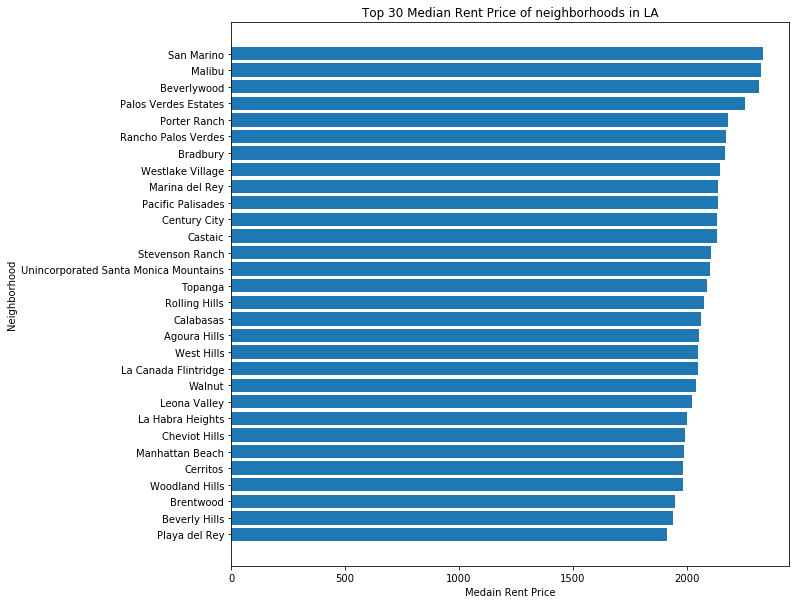

In [11]:
la_data = la_data.sort_values('Median Rent Price', ascending = False)

import matplotlib.pyplot as plt
plt.figure(figsize = (10, 10))
plt.barh(la_data.iloc[:30, 0],la_data.iloc[:30, 1])
plt.gca().invert_yaxis()
plt.title('Top 30 Median Rent Price of neighborhoods in LA')
plt.xlabel('Medain Rent Price')
plt.ylabel('Neighborhood')

## 3. Explore Each Neighborhood

#### Use Foursquare explore function to get nearby venues of each neighberhood.

In [12]:
temp_data = pd.DataFrame(columns = ['Venue', 'Venue Category', 'Venue Latitude', 'Venue Longitude', 'Neighborhood'])
temp_data

,Venue,Venue Category,Venue Latitude,Venue Longitude,Neighborhood


In [13]:
venue_data = pd.DataFrame(columns = ['Venue', 'Venue Category', 'Venue Latitude', 'Venue Longitude', 'Neighborhood'])

for i in range(la_data.shape[0]):
    lat = la_data.loc[i, 'Latitude']
    lng = la_data.loc[i, 'Longitude']
    
    CLIENT_ID = 'NY3Y0NMSA2AMHLPV521V4TUKK42A5WAUIHRQONMJAOJ2L1MO'
    CLIENT_SECRET = 'HJIGFFCSETXGCXLFQ5D2R5KPEH2I4DUWV1CEW01J5WKPXMRP'
    VERSION = '20191215'
    radius = 500
    limit = 100
    
    url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, lat, lng, VERSION, radius, limit)
    url
    
    results = requests.get(url).json()
    
    try:
        venues = results['response']['groups'][0]['items']
        nearby_venues = json_normalize(venues) # flatten JSON
        filtered_col = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
        nearby_venues = nearby_venues[filtered_col]
        nearby_venues['Neighborhood'] = la_data.loc[i, 'Neighborhood']
        nearby_venues.columns = ['Venue', 'Venue Category', 'Venue Latitude', 'Venue Longitude', 'Neighborhood']
        venue_data = venue_data.append(nearby_venues)
    except:
        pass
venue_data.head(50)

,Venue,Venue Category,Venue Latitude,Venue Longitude,Neighborhood
0,Orange Door Sushi,"[{'id': '4bf58dd8d48988d1d2941735', 'name': 'S...",34.032485,-118.299368,Adams-Normandie
1,Shell,"[{'id': '4bf58dd8d48988d113951735', 'name': 'G...",34.033095,-118.300025,Adams-Normandie
2,Sushi Delight,"[{'id': '4bf58dd8d48988d1d2941735', 'name': 'S...",34.032445,-118.299525,Adams-Normandie
3,Little Xian,"[{'id': '4bf58dd8d48988d1d2941735', 'name': 'S...",34.032292,-118.299465,Adams-Normandie
4,Tacos La Estrella,"[{'id': '4bf58dd8d48988d151941735', 'name': 'T...",34.032230,-118.300757,Adams-Normandie
5,LAE Locksmith Services 24/7,"[{'id': '52f2ab2ebcbc57f1066b8b1e', 'name': 'L...",34.032418,-118.297324,Adams-Normandie
6,Adlong market,"[{'id': '4bf58dd8d48988d118951735', 'name': 'G...",34.032242,-118.296229,Adams-Normandie
7,Loren Miller Recreational Park,"[{'id': '4bf58dd8d48988d1e7941735', 'name': 'P...",34.031335,-118.303717,Adams-Normandie
8,Richardson Family Park,"[{'id': '4bf58dd8d48988d163941735', 'name': 'P...",34.028221,-118.297457,Adams-Normandie
9,Diaz Locksmith,"[{'id': '52f2ab2ebcbc57f1066b8b1e', 'name': 'L...",34.033002,-118.294560,Adams-Normandie


#### Get category name for each venue.

In [14]:
category_list = []
for category in venue_data['Venue Category']:
        category = category[0]['name']
        category_list.append(category)
venue_data['Venue Category'] = category_list

#### Analyze the number of venues around each neighborhood.

In [15]:
venue_grouped = venue_data.groupby('Neighborhood').count()
print('Out of 259 neighborhoods in LA, only {} of them have venues around with the given coordinates values and radius point of 500 meters.'.format(venue_grouped.shape[0]))

Out of 259 neighborhoods in LA, only 228 of them have venues around with the given coordinates values and radius point of 500 meters.


In [16]:
venue_grouped = venue_grouped.sort_values('Venue', ascending = False)
venue_grouped.head()

,Venue,Venue Category,Venue Latitude,Venue Longitude
Neighborhood,,,,
Downtown,100,100,100,100
Beverly Grove,100,100,100,100
Koreatown,91,91,91,91
Hermosa Beach,70,70,70,70
Los Feliz,68,68,68,68


<function matplotlib.pyplot.show(*args, **kw)>

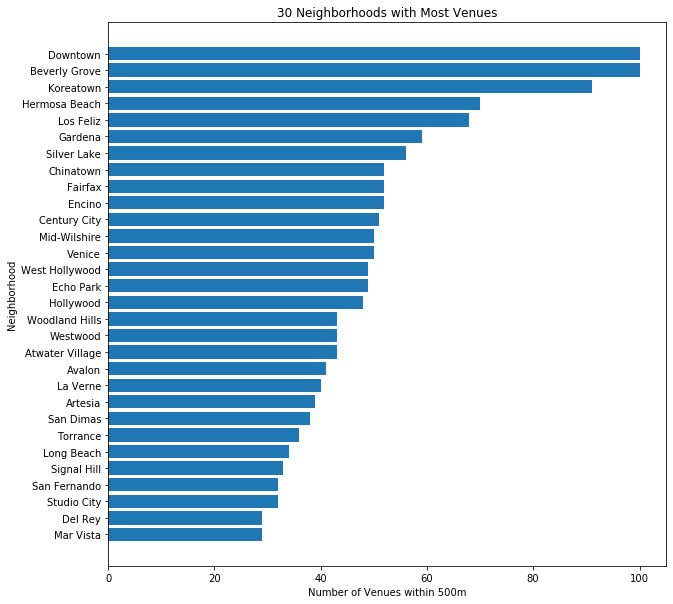

In [17]:
plt.figure(figsize = (10, 10))
plt.barh(venue_grouped.index[:30], venue_grouped.iloc[:30, 0])
plt.gca().invert_yaxis()
plt.title('30 Neighborhoods with Most Venues')
plt.xlabel('Number of Venues within 500m')
plt.ylabel('Neighborhood')
plt.show

#### Combine rent price table and venue table.

In [18]:
venue_data = venue_data.set_index('Neighborhood')
la_venues = la_data.merge(venue_data, on = 'Neighborhood')

In [19]:
la_venues.head()

,Neighborhood,Median Rent Price,Latitude,Longitude,Venue,Venue Category,Venue Latitude,Venue Longitude
0,San Marino,2332.38,34.123433,-118.109823,Yoshida,Sushi Restaurant,34.120469,-118.109394
1,San Marino,2332.38,34.123433,-118.109823,Desert Gardens,Garden,34.126885,-118.110173
2,San Marino,2332.38,34.123433,-118.109823,Starbucks,Coffee Shop,34.122358,-118.105826
3,San Marino,2332.38,34.123433,-118.109823,San Marino Seafood Restaurant & Market,Seafood Restaurant,34.121264,-118.107107
4,San Marino,2332.38,34.123433,-118.109823,The Fresh Gourmet,American Restaurant,34.120298,-118.109745


#### One hot encoding

In [21]:

la_onehot = pd.get_dummies(la_venues['Venue Category'], prefix = '', prefix_sep = '')
la_onehot['Neighborhood'] = la_venues['Neighborhood']
ordered_col = la_onehot.columns[:-1].insert(0, la_onehot.columns[-1])
la_onehot = la_onehot[ordered_col]
la_onehot.head()

,Neighborhood,ATM,Accessories Store,African Restaurant,Alternative Healer,American Restaurant,Antique Shop,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Workshop,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bathing Area,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cable Car,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Carpet Store,Cemetery,Check Cashing Service,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,College Bookstore,College Cafeteria,College Residence Hall,College Theater,Comedy Club,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Dance Studio,Deli / Bodega,Dentist's Office,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Disc Golf,Discount Store,Dive Bar,Dive Spot,Doctor's Office,Dog Run,Donburi Restaurant,Doner Restaurant,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Service,Event Space,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Film Studio,Financial or Legal Service,Fish & Chips Shop,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Football Stadium,Fraternity House,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,Gift Shop,Golf Course,Golf Driving Range,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,High School,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Insurance Office,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Leather Goods Store,Light Rail Station,Lighting Store,Lingerie Store,Liquor Store,Locksmith,Lounge,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Motel,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Outdoor Supply Store,Outdoors & Recreation,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Photography Lab,Pier,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Pool Hall,Pop-Up Shop,Print Shop,Pub,Public Art,Racetrack,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Rental Service,Reservoir,Residential Building (Apartment / Condo),Resort,Restaurant,River,Road,Rock Club,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Satay Restaurant,Scandinavian Restaurant,Scenic Lookout,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shabu-Shabu Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Fi

In [22]:
la_onehot.shape

(3411, 325)

#### Calculate the mean of the frequency of occurrence of each category in each neighborhood.

In [23]:
la_mean = la_onehot.groupby('Neighborhood').mean().reset_index()
la_mean.head()

,Neighborhood,ATM,Accessories Store,African Restaurant,Alternative Healer,American Restaurant,Antique Shop,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Workshop,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bathing Area,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cable Car,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Carpet Store,Cemetery,Check Cashing Service,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,College Bookstore,College Cafeteria,College Residence Hall,College Theater,Comedy Club,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Dance Studio,Deli / Bodega,Dentist's Office,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Disc Golf,Discount Store,Dive Bar,Dive Spot,Doctor's Office,Dog Run,Donburi Restaurant,Doner Restaurant,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Service,Event Space,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Film Studio,Financial or Legal Service,Fish & Chips Shop,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Football Stadium,Fraternity House,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,Gift Shop,Golf Course,Golf Driving Range,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,High School,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Insurance Office,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Leather Goods Store,Light Rail Station,Lighting Store,Lingerie Store,Liquor Store,Locksmith,Lounge,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Motel,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Outdoor Supply Store,Outdoors & Recreation,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Photography Lab,Pier,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Pool Hall,Pop-Up Shop,Print Shop,Pub,Public Art,Racetrack,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Rental Service,Reservoir,Residential Building (Apartment / Condo),Resort,Restaurant,River,Road,Rock Club,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Satay Restaurant,Scandinavian Restaurant,Scenic Lookout,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shabu-Shabu Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Fi

In [24]:
la_mean.shape

(228, 325)

#### Find the top 5 most common venues in each neighborhood.

In [25]:
num_top_venues = 5

for neib in la_mean['Neighborhood']:
    print('-----'+neib+'-----')
    temp = la_mean[la_mean['Neighborhood'] == neib].T.reset_index()
    temp = temp.iloc[1:]
    temp.columns = ['Venue', 'Frequency']
    temp['Frequency'] = temp['Frequency'].astype(float)
    temp = temp.round({'Frequency': 2})
    temp = temp.sort_values('Frequency', ascending = False).reset_index(drop = True)
    print(temp.head(num_top_venues))
    print('\n')

-----Adams-Normandie-----
              Venue  Frequency
0  Sushi Restaurant        0.3
1         Locksmith        0.2
2              Park        0.1
3     Grocery Store        0.1
4        Taco Place        0.1


-----Agoura Hills-----
                           Venue  Frequency
0                           Park        1.0
1            Monument / Landmark        0.0
2  Paper / Office Supplies Store        0.0
3          Outdoors & Recreation        0.0
4           Outdoor Supply Store        0.0


-----Alhambra-----
                     Venue  Frequency
0        Convenience Store       0.33
1  Health & Beauty Service       0.08
2      Sporting Goods Shop       0.08
3           Breakfast Spot       0.08
4       Mexican Restaurant       0.08


-----Alondra Park-----
                   Venue  Frequency
0       Football Stadium        0.5
1                   Park        0.5
2                    ATM        0.0
3           Noodle House        0.0
4  Outdoors & Recreation        0.0


-----Al

#### Create a new dataframe of the 10 most common venues in each neighborhood.

In [26]:
num_top_venues = 10

col_list = ['Neighborhood']
indicators = ['st', 'nd', 'rd']
for i in range(num_top_venues):
    try:
        col_list.append('{}{} Most Common Venue'.format(i+1,indicators[i]))
    except:
        col_list.append('{}th Most Common Venue'.format(i+1))
        
# create a new dataframe
la_venues_sorted = pd.DataFrame(columns=col_list)
la_venues_sorted['Neighborhood'] = la_mean['Neighborhood']

In [27]:
for i in range(la_mean.shape[0]):
    venues = la_mean.iloc[i, 1:].sort_values(ascending = False).index.values[:num_top_venues]
    la_venues_sorted.iloc[i, 1:] = venues
la_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adams-Normandie,Sushi Restaurant,Locksmith,Grocery Store,Playground,Taco Place,Park,Gas Station,Farm,Eastern European Restaurant,Drugstore
1,Agoura Hills,Park,Flea Market,Drugstore,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Service,Event Space
2,Alhambra,Convenience Store,Breakfast Spot,Video Store,Sporting Goods Shop,Fast Food Restaurant,Pet Store,Pizza Place,Mexican Restaurant,Health & Beauty Service,Department Store
3,Alondra Park,Park,Football Stadium,Fabric Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Service,Event Space
4,Altadena,Mexican Restaurant,Ice Cream Shop,Campground,Coffee Shop,Dive Bar,Museum,Hardware Store,Pharmacy,Smoke Shop,Breakfast Spot


## 4. Cluster Neighborhoods

Run k-means to cluster the neighborhood into 3 clusters.

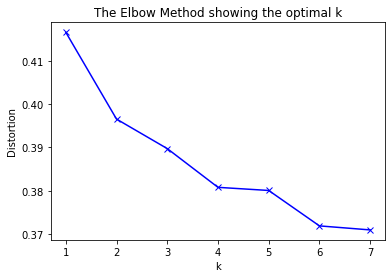

In [39]:
from scipy.spatial.distance import cdist

la_cluster = la_mean.drop('Neighborhood', axis = 1)
distortions = []
K = range(1,8)

for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(la_cluster)
    distortions.append(sum(np.min(cdist(la_cluster, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / la_cluster.shape[0])
    
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [29]:

kclusters = 4
kmeans = KMeans(n_clusters = kclusters, random_state = 0).fit(la_cluster)
la_venues = la_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

#### Merge the rent price table with the cluster table.

In [30]:
la_venues_sorted.head()

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,Adams-Normandie,Sushi Restaurant,Locksmith,Grocery Store,Playground,Taco Place,Park,Gas Station,Farm,Eastern European Restaurant,Drugstore
1,1,Agoura Hills,Park,Flea Market,Drugstore,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Service,Event Space
2,3,Alhambra,Convenience Store,Breakfast Spot,Video Store,Sporting Goods Shop,Fast Food Restaurant,Pet Store,Pizza Place,Mexican Restaurant,Health & Beauty Service,Department Store
3,1,Alondra Park,Park,Football Stadium,Fabric Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Service,Event Space
4,0,Altadena,Mexican Restaurant,Ice Cream Shop,Campground,Coffee Shop,Dive Bar,Museum,Hardware Store,Pharmacy,Smoke Shop,Breakfast Spot


In [31]:
la_merged = la_data.join(la_venues_sorted.set_index('Neighborhood'), on = 'Neighborhood')
la_merged = la_merged.drop(la_merged[np.isnan(la_merged['Cluster Labels'])].index)
la_merged['Cluster Labels'] = la_merged['Cluster Labels'].astype(int)
la_merged = la_merged.reset_index(drop=True)
la_merged.head()

,Neighborhood,Median Rent Price,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,San Marino,2332.38,34.123433,-118.109823,0,Garden,Café,American Restaurant,Art Gallery,Mobile Phone Shop,Seafood Restaurant,Sushi Restaurant,Coffee Shop,Botanical Garden,Bank
1,Malibu,2326.57,34.022940,-118.799901,0,Food,Hotel,IT Services,Locksmith,Gym,Italian Restaurant,Yoga Studio,Fabric Shop,Dumpling Restaurant,Eastern European Restaurant
2,Beverlywood,2316.14,34.041931,-118.393355,0,Business Service,Hotel,Burrito Place,Park,Boutique,Food Truck,Coffee Shop,Falafel Restaurant,Electronics Store,Ethiopian Restaurant
3,Palos Verdes Estates,2256.38,33.785563,-118.399546,0,Scenic Lookout,Flea Market,Drugstore,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Service,Event Space
4,Porter Ranch,2179.35,34.278533,-118.547691,1,Park,Water Park,Fabric Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Service


#### Visualize the resulting clusters

In [32]:
# create map
cluster_map = folium.Map(location=[la_lat, la_lng], zoom_start=10)

# set color scheme for the clusters
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array] 
rainbow

['#8000ff', '#2adddd', '#d4dd80', '#ff0000']

In [33]:
# add markers to the map
markers_colors = []
for lat, lng, neib, cluster in zip(la_merged['Latitude'], la_merged['Longitude'], la_merged['Neighborhood'], la_merged['Cluster Labels']):
    label = folium.Popup(neib + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(cluster_map)
       
cluster_map

## 5. Examine Clusters

#### Cluster 0

In [34]:
cluster_col = la_merged.columns[[0]+ np.arange(5, la_merged.shape[1]).tolist()]
cluster = la_merged.loc[la_merged['Cluster Labels'] == 0, cluster_col]
print('There are {} neighborhoods in Cluster 0.'.format(cluster.shape[0]))
cluster.head()

There are 186 neighborhoods in Cluster 0.


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,San Marino,Garden,Café,American Restaurant,Art Gallery,Mobile Phone Shop,Seafood Restaurant,Sushi Restaurant,Coffee Shop,Botanical Garden,Bank
1,Malibu,Food,Hotel,IT Services,Locksmith,Gym,Italian Restaurant,Yoga Studio,Fabric Shop,Dumpling Restaurant,Eastern European Restaurant
2,Beverlywood,Business Service,Hotel,Burrito Place,Park,Boutique,Food Truck,Coffee Shop,Falafel Restaurant,Electronics Store,Ethiopian Restaurant
3,Palos Verdes Estates,Scenic Lookout,Flea Market,Drugstore,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Service,Event Space
6,Bradbury,Stables,Yoga Studio,Falafel Restaurant,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Service,Event Space,Fabric Shop


#### Cluster 1

In [35]:
cluster_col = la_merged.columns[[0]+ np.arange(5, la_merged.shape[1]).tolist()]
cluster = la_merged.loc[la_merged['Cluster Labels'] == 1, cluster_col]
print('There are {} neighborhoods in Cluster 1.'.format(cluster.shape[0]))
cluster.head()

There are 11 neighborhoods in Cluster 1.


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Porter Ranch,Park,Water Park,Fabric Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Service
5,Rancho Palos Verdes,Park,Video Store,Financial or Legal Service,Event Space,Drugstore,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant
11,Castaic,Park,Furniture / Home Store,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Service,Event Space
14,Agoura Hills,Park,Flea Market,Drugstore,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Service,Event Space
18,La Habra Heights,Park,Flea Market,Drugstore,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Service,Event Space


#### Cluster 2

In [36]:
cluster_col = la_merged.columns[[0]+ np.arange(5, la_merged.shape[1]).tolist()]
cluster = la_merged.loc[la_merged['Cluster Labels'] == 2, cluster_col]
print('There are {} neighborhoods in Cluster 2.'.format(cluster.shape[0]))
cluster.head()

There are 2 neighborhoods in Cluster 2.


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
20,Manhattan Beach,African Restaurant,Coffee Shop,Yoga Studio,Falafel Restaurant,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Service,Event Space
62,Glendora,Coffee Shop,Yoga Studio,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Service,Event Space,Fabric Shop


#### Cluster 3

In [37]:
cluster_col = la_merged.columns[[0]+ np.arange(5, la_merged.shape[1]).tolist()]
cluster = la_merged.loc[la_merged['Cluster Labels'] == 3, cluster_col]
print('There are {} neighborhoods in Cluster 3.'.format(cluster.shape[0]))
cluster.head()

There are 29 neighborhoods in Cluster 3.


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
41,Playa Vista,Mexican Restaurant,Coffee Shop,Mediterranean Restaurant,Breakfast Spot,American Restaurant,Pizza Place,Park,Automotive Shop,Café,Falafel Restaurant
66,Lake Balboa,Mexican Restaurant,Pharmacy,Steakhouse,Automotive Shop,Sandwich Place,Bubble Tea Shop,Cupcake Shop,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant
72,Del Rey,Mexican Restaurant,Bakery,Coffee Shop,Smoke Shop,Bus Station,Food,Café,Food Truck,Music Store,Sandwich Place
74,West Covina,Mexican Restaurant,Trail,Convenience Store,Construction & Landscaping,Juice Bar,Sports Bar,Dry Cleaner,Butcher,Eastern European Restaurant,Electronics Store
75,Pasadena,Mexican Restaurant,Fast Food Restaurant,Convenience Store,Rental Car Location,Burger Joint,Middle Eastern Restaurant,Cupcake Shop,Southern / Soul Food Restaurant,Food & Drink Shop,Café
